## Вебинар 6. Двухуровневые модели рекомендаций

### Подготовка

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация (модель 1 уровня)
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.recommenders import MainRecommender, BaselineRecommender
# from src.recommenders import popularity_recommendation
from src.utils import prefilter_items

In [16]:
# !pip install lightgbm

In [17]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# Удалим товары,которые вызывают ошибки
data = data[~data['user_id'].isin(['296', '1813', '1984', '2498'])]

In [18]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [35]:
# Предварительная фильтрация
data = prefilter_items(data=data, take_n_popular=5000, item_features=item_features)

In [20]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks, val_lvl_2_size_weeks = 6, 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

# data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
# data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.99
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0,1.29


In [21]:
%%time
# Создадим экземпляр класса MainRecommender
recommender = MainRecommender(data_train_lvl_1)


Wall time: 18.6 s


In [22]:
# Проверка раборты рекомендаций
user = 2375
pd.DataFrame({'als_recs': [recommender.get_als_recommendations(user, N=50)],
              'own_recs': [recommender.get_own_recommendations(user, N=50)],
              'similar_items_recs': [recommender.get_similar_items_recommendation(user, N=50)],
              'similar_users_recs': [recommender.get_similar_users_recommendation(user, N=50)]}
            ).T

,0
als_recs,"[981760, 871756, 899624, 844179, 923746, 10980..."
own_recs,"[948640, 1036501, 887219, 918046, 847962, 8966..."
similar_items_recs,"[868764, 889731, 1046545, 947858, 9527160, 122..."
similar_users_recs,"[997025, 1012801, 279994, 1036093, 974265, 995..."


# Задание 1

### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (`k=50`)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна
- Дают ли own recommendtions + top-popular лучший recall?  

In [23]:
# your_code

#### Создадим результирующию таблицу, куда будем добавлять рекомендации

In [24]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
result_lvl_1.head(2)

,user_id,actual
0,1,"[999999, 865456, 872137, 878285, 879988, 89088..."
1,2,"[999999, 838136, 839656, 866211, 873916, 89386..."


#### C помощью классов `recommender` и `baseline` будем добавлять в результирующую таблицу по 50 рекомендаций различными методами

In [25]:
%%time
result_lvl_1['als_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(user=x, N=50))
result_lvl_1['own_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(user=x, N=50))
result_lvl_1['similar_items_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(user=x, N=50))

Wall time: 3min 6s


In [26]:
baseline = BaselineRecommender()

In [29]:
%%time
result_lvl_1['popular_recs'] = result_lvl_1['user_id'].apply(lambda x: baseline.popularity_recommendation(data=data_train_lvl_1, n=50))
result_lvl_1['rand_recs'] = result_lvl_1['user_id'].apply(lambda x: baseline.random_recommendation(data=data_train_lvl_1, n=50))

Wall time: 7min 22s


In [30]:
result_lvl_1['own+pop'] = result_lvl_1['own_recs'] + result_lvl_1['popular_recs']

In [31]:
result_lvl_1.head(2)

,user_id,actual,als_recs,own_recs,similar_items_recs,popular_recs,rand_recs,own+pop
0,1,"[999999, 865456, 872137, 878285, 879988, 89088...","[896292, 1082212, 960732, 824758, 856942, 1006...","[1049998, 856942, 9297615, 1074612, 900875, 55...","[896292, 8119097, 1098066, 1127825, 877391, 92...","[1029743, 916122, 6533765, 1106523, 995242, 55...","[907860, 6039662, 942166, 15596933, 896379, 11...","[1049998, 856942, 9297615, 1074612, 900875, 55..."
1,2,"[999999, 838136, 839656, 866211, 873916, 89386...","[1004906, 1127831, 916122, 5569230, 961554, 86...","[1076580, 854646, 7433029, 1107760, 5567582, 9...","[1137346, 5569845, 1133018, 1038746, 985999, 8...","[1029743, 916122, 6533765, 1106523, 995242, 55...","[884333, 8118517, 920695, 12263439, 1004762, 9...","[1076580, 854646, 7433029, 1107760, 5567582, 9..."


#### Расчет recall@k

In [32]:
k=50

In [33]:
# recall_at_k

for model in result_lvl_1.columns[2:-1].tolist():
    print(
        model, '-',
        result_lvl_1.apply(lambda row: recall_at_k(recommended_list=row[model], bought_list=row['actual'], k=k), axis=1).mean(),
    )
print('own+pop', '-',
    result_lvl_1.apply(lambda row: recall_at_k(row['own+pop'], row['actual'], k=k*2), axis=1).mean()
)

als_recs - 0.10511877546045341
own_recs - 0.11220478269894851
similar_items_recs - 0.06615953915907333
popular_recs - 0.09536682086259549
rand_recs - 0.0047887286945161
own+pop - 0.2020579740810449


In [34]:
# precision_at_k
k=5
for model in result_lvl_1.columns[2:-1].tolist():
    print(
        model, '-',
        result_lvl_1.apply(lambda row: precision_at_k(recommended_list=row[model], bought_list=row['actual'], k=k), axis=1).mean(),
    )
print('own+pop', '-',
    result_lvl_1.apply(lambda row: precision_at_k(row['own+pop'], row['actual'], k=k*2), axis=1).mean()
)

als_recs - 0.1657919400187421
own_recs - 0.2009372071227719
similar_items_recs - 0.07900656044985933
popular_recs - 0.14686035613870457
rand_recs - 0.003842549203373947
own+pop - 0.16148078725398352


**ВЫВОД** Нет, максимальный `recall@k` на модели `own_recommendations` добавлением top_5000 модель не улучшается

### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [47]:
result_lvl_1_var_2 = result_lvl_1.copy(deep=True)
result_lvl_1_var_2 = result_lvl_1_var_2[['user_id', 'actual']]

In [49]:
result_lvl_1_var_2.head(2)

,user_id,actual
0,1,"[999999, 865456, 872137, 878285, 879988, 89088..."
1,2,"[999999, 838136, 839656, 866211, 873916, 89386..."


In [50]:
%%time
for k in [20, 50, 100, 200, 500]:
    print(f'k={k}')
    result_lvl_1_var_2[f'own_at_k={k}'] = result_lvl_1_var_2['user_id'].apply(lambda x: recommender.get_own_recommendations(user=x, N=k))
print('The End')

k=20
k=50
k=100
k=200
k=500
The End
Wall time: 4min 5s


In [51]:
result_lvl_1_var_2.head(1).T

,0
user_id,1
actual,"[999999, 865456, 872137, 878285, 879988, 89088..."
own_at_k=20,"[1049998, 856942, 9297615, 1074612, 900875, 55..."
own_at_k=50,"[1049998, 856942, 9297615, 1074612, 900875, 55..."
own_at_k=100,"[1049998, 856942, 9297615, 1074612, 900875, 55..."
own_at_k=200,"[1049998, 856942, 9297615, 1074612, 900875, 55..."
own_at_k=500,"[1049998, 856942, 9297615, 1074612, 900875, 55..."


In [53]:
recals_at_list_k = pd.DataFrame(
    [
        (
            k, 
            result_lvl_1_var_2.apply(lambda row: recall_at_k(recommended_list=row[f'own_at_k={k}'], 
                                                             bought_list=row['actual'], k=k), axis=1).mean()
        ) for k in [20, 50, 100, 200, 500]
    ], columns={'k', 'value'}).sort_values(by='value', ascending=False)

recals_at_list_k

,k,value
4,500,0.424883
3,200,0.262974
2,100,0.170208
1,50,0.112205
0,20,0.069763


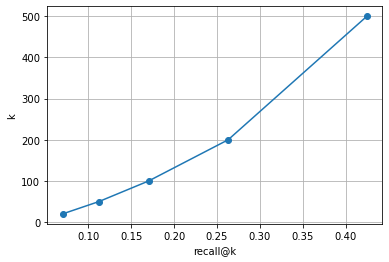

In [65]:
plt.plot(recals_at_list_k['value'],
         recals_at_list_k['k'], 
         marker='o')
plt.xlabel('recall@k')
plt.ylabel('k')
plt.grid();

In [61]:
result_lvl_1_var_2.apply(lambda row: precision_at_k(recommended_list=row[f'own_at_k=500'], 
                                                    bought_list=row['actual'], 
                                                    k=5), axis=1).mean()

0.2009372071227719

----

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [58]:
recals_at_list_k.sort_values(by='k', ascending=False).head(1)

,k,value
4,500,0.424883


# Задание 2. Обучите модель 2-ого уровня, при этом:
- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
- Вырос ли precision@5 при использовании двухуровневой модели?

In [45]:
# your_code

### Создание таргета - таблицы для обучения модели 2 уровня

#### создание списков кандидатов фильтрацией первого уровня

In [36]:
%%time
data_train_lvl_2 = data_val_lvl_1.copy()
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique()).rename(columns={0: 'user_id'})

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

#создание списков кандидатов на певом уровне
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(
    lambda x: recommender.get_own_recommendations(x, N=100))

Wall time: 50.2 s


In [37]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[13986925, 834103, 1105426, 1119399, 1097350, ..."
1,2021,"[1041390, 950935, 1079528, 1119454, 1019142, 8..."


[Как эффективно вытянуть нашу обучающую выборку](https://stackoverflow.com/questions/53218931/how-to-unnest-explode-a-column-in-a-pandas-dataframe)

#### разворачивание в столбцы

In [38]:
df = pd.DataFrame(
    {
        'user_id':users_lvl_2['user_id'].values.repeat(len(users_lvl_2['candidates'][0])),
        'item_id':np.concatenate(users_lvl_2['candidates'].values)
    })

In [39]:
df.head(200).T

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
user_id,2070,2070,2070,2070,2070,2070,2070,2070,2070,2070,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
item_id,13986925,834103,1105426,1119399,1097350,879194,948640,13511722,1138596,869868,...,856060,1130777,12263692,951197,7169090,998556,837495,999270,873044,9527290


#### создание таргета

In [40]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

In [41]:
targets_lvl_2.head(200).T

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
user_id,2070.0,2070.0,2070.0,2070.0,2070.0,2070.0,2070.0,2070.0,2070.0,2070.0,...,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0
item_id,13986925.0,834103.0,834103.0,834103.0,834103.0,834103.0,834103.0,834103.0,834103.0,834103.0,...,998519.0,6424471.0,912902.0,1074499.0,1025535.0,1131974.0,895166.0,847790.0,869868.0,948670.0
target,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
targets_lvl_2['target'].mean()

0.09379790306807069

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

### Генерация признаков

In [43]:
display(item_features.head(2), user_features.head(2))

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


**Фичи user_id:**
- [x] Средний чек
- [ ] Средняя сумма покупки 1 товара в каждой категории
- [ ] Кол-во покупок в каждой категории
- [ ] Частотность покупок раз/месяц
- [ ] Долю покупок в выходные
- [ ] Долю покупок утром/днем/вечером

**Фичи item_id**:
- [ ] Кол-во покупок в неделю
- [ ] Среднее ол-во покупок 1 товара в категории в неделю
- [ ] (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
- [ ] Цена (Можно посчитать из retil_train.csv)
- [ ] Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
- [ ] (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
- [ ] (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
- [ ] (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

##### добавим средний чек

In [44]:
avg_value = user_features.merge(right=data, on='user_id', how='left') \
                            .groupby(by='user_id').mean() \
                            .reset_index()[['user_id', 'sales_value']] \
                            .rename(columns={'sales_value': 'avg_value'})

user_features = user_features.merge(right=avg_value, on='user_id', how='left')

##### добавим  ___ ??

In [45]:
# data.head(3)

In [46]:
# data.week_no.value_counts()

---

### Присоединние к таргету признаков из `item_features`, `user_features`

In [47]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
# targets_lvl_2.head(2)

In [48]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [49]:
cat_feats = X_train.columns[1:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [50]:
y_train.mean()

target    0.093798
dtype: float64

### Обучение `LGBMClassifier`

In [51]:
lgb_params = { 
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 4,
    'categorical_column': cat_feats,
    'random_state': 27,
#     'metrics' : 
}

In [52]:
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)

C:\Users\carne\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\carne\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['item_id', 'manufacturer', 'department',
                                   'brand', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'age_desc', 'marital_status_code',
                                   'income_desc', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc', 'avg_value'],
               max_depth=4, n_estimators=500, random_state=27)

In [54]:
train_preds = lgb.predict_proba(X_train)[:, 1]

Создание таблицы с результатами

In [55]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

df_res = targets_lvl_2[['user_id', 'item_id']]

#добавление неотсортированных кандидатов
candidats = df_res.groupby('user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(candidats, on=['user_id'], how='left').rename(columns={'item_id': 'own'})

#добавление отсортированных по LGBMClassifier кандидатов
df_res['train_preds'] = train_preds
df_res.sort_values('train_preds', ascending=False, inplace=True)
top_candidats = df_res.groupby('user_id')['item_id'].apply(list)
result_lvl_2 = result_lvl_2.merge(top_candidats, on=['user_id'], how='left').rename(columns={'item_id': 'lgb'})

<ipython-input-55-86d32ba3b0c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['train_preds'] = train_preds
<ipython-input-55-86d32ba3b0c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res.sort_values('train_preds', ascending=False, inplace=True)


In [56]:
result_lvl_2 = result_lvl_2.loc[~result_lvl_2['lgb'].isnull()]
result_lvl_2.head(3)

,user_id,actual,own,lgb
0,1,"[856942, 865456, 999999, 907957, 914190, 95195...","[1049998, 1049998, 1049998, 856942, 856942, 92...","[9527558, 9527558, 9527558, 9655212, 9655212, ..."
2,6,"[946489, 999999, 825541, 870315, 873654, 87414...","[849618, 1041259, 13003092, 5570685, 948640, 9...","[1098844, 1098844, 1063207, 821083, 1098284, 9..."
3,7,"[840386, 889774, 898068, 909714, 999999, 10031...","[896666, 998519, 1086732, 949836, 7147142, 894...","[949836, 1079023, 9527174, 886965, 9338009, 84..."


In [57]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

0.12158730158730069

In [58]:
result_lvl_2.apply(lambda row: precision_at_k(row['own'], row['actual'], k=5), axis=1).mean()

0.08772486772486753

## Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 